# Model selection and evaluation

## 0.0 Notebook setup

### X.X Colab Setup

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
! mkdir data

In [3]:
! cp "/content/gdrive/My Drive/colab-data/combined.csv" ./data/

In [4]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4463191038221845003
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14465892352
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8491217056128692569
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [6]:
!pip install --quiet transformers

     |████████████████████████████████| 4.2 MB 32.2 MB/s 
     |████████████████████████████████| 596 kB 65.9 MB/s 
     |████████████████████████████████| 6.6 MB 69.9 MB/s 
     |████████████████████████████████| 84 kB 4.0 MB/s 


### X.X General setup

In [7]:
import warnings

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", DeprecationWarning)

In [8]:
# Statistics
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, norm, skew, kurtosis

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection and evaluation
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, precision_recall_fscore_support, roc_curve, auc, accuracy_score

# Model building
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, Dense, Flatten, LSTM, Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# BERT-specific
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

In [9]:
# Local
# data = '../data/combined.csv'

# Colab
data = './data/combined.csv'

review_samples = pd.read_csv(data)

In [10]:
# Create sentiment axis label for plots
sentiment = ['Not Useful', 'Useful']

# Check split of useful / not useful
review_samples['helpful'].value_counts()

0    24294
1     5697
Name: helpful, dtype: int64

## X.X Combined data

In [11]:
labels = review_samples['helpful'].astype(int)

### X.X Naive Bayes - Combined

In [12]:
reviews = review_samples['review_processed'].fillna('no review')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.2, random_state=0)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)

X_train_tfidf = tf_idf.fit_transform(X_train)
X_dev_tfidf = tf_idf.transform(X_dev)
X_test_tfidf = tf_idf.transform(X_test)

# Use SMOTE to resolve class imbalance
sm = SMOTE(random_state=0)
X_train_tfidf, y_train = sm.fit_resample(X_train_tfidf, y_train)

In [14]:
# Build model
nb_model = MultinomialNB(alpha=1.8)

# Fit model
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=1.8)

In [15]:
# Evaluate model accuracy
train_acc = nb_model.score(X_train_tfidf, y_train)
dev_acc = nb_model.score(X_dev_tfidf, y_dev)
test_acc = nb_model.score(X_test_tfidf, y_test)

print(train_acc, dev_acc, test_acc)

0.9394500445724474 0.5013337779259753 0.5160860143357227


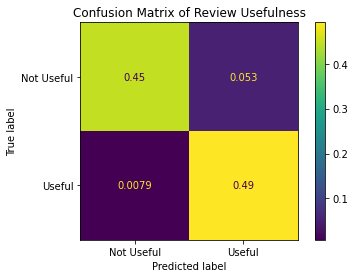

In [16]:
# Plot confusion matrix on training data
y_true = y_train
y_pred = nb_model.predict(X_train_tfidf)

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

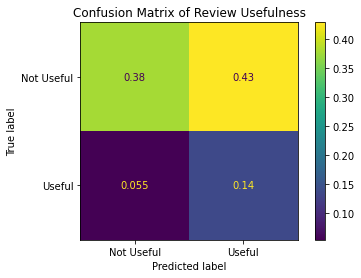

In [17]:
# Evaluate model on test data and plot confusion matrix
y_true = y_test
y_pred = nb_model.predict(X_test_tfidf)

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

AUC: 0.5925


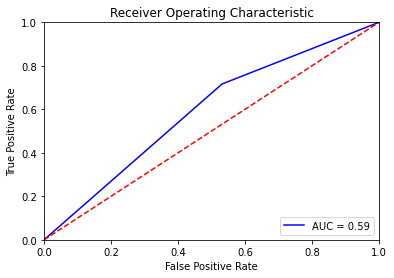

In [18]:
fpr, tpr, threshold = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')

# Plot ROC AUC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [19]:
# Evaluate model
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print("Model performance metrics on test data")
print("Accuracy: {:.4f}\nPrecision: {:.4f}\nRecall: {:.4f}\nF1-score: {:.4f}".format(test_acc, precision, recall, f1))

Model performance metrics on test data
Accuracy: 0.5161
Precision: 0.7527
Recall: 0.5161
F1-score: 0.5624


### X.X Tokenization and analytics - Combined

In [20]:
# Set tokenization parameters
num_words = 4000
num_len = 512
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

# Tokenize review text
tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)

# Additional tokenization parameters
max_words = len(tokenizer.word_index)
max_len = max([len(x) for x in sequences])

# Pad review text tokens
review_tokens = pad_sequences(sequences, padding=pad_type, truncating=trunc_type, maxlen=num_len)

In [21]:
len(tokenizer.word_counts)

19777

In [22]:
vocab = pd.DataFrame(tokenizer.word_counts.items(), columns=['word', 'frequency'])
vocab.sort_values('frequency', ascending=False).head(10)

,word,frequency
28,great,8516
16,good,6451
128,use,5996
1,work,5295
167,one,5018
93,get,4860
5,well,4385
191,like,4169
34,love,4128
24,product,3926


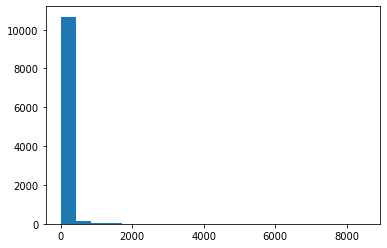

In [23]:
filtered_vocab = vocab[vocab['frequency'] > 1]
plt.hist(filtered_vocab['frequency'], bins=20)
plt.show()

In [25]:
print('Max words in vocabulary: {}'.format(max_words))
print('Max sequence length: {}'.format(max_len))
print('\n')

print('Words allowed in vocabulary: {}'.format(num_words))
print('Allowed sequence length: {}'.format(num_len))
print('\n')

print('Example processed review:')
print(review_samples['review_processed'].iloc[500])
print('\n')

print('Example tokenized review:')
print(review_tokens[500])

Max words in vocabulary: 19778
Max sequence length: 977


Words allowed in vocabulary: 4000
Allowed sequence length: 512


Example processed review:
headline item say stainless steel read description say zinc confirm zinc cast nearly nice show image false advertising return refund


Example tokenized review:
[   1  105   47 1943  814  223  547   47    1 2479    1 1754  878   21
  235 1149 2909 2891  121  694    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0 

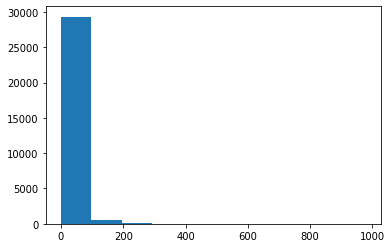

In [26]:
seq_len = [len(x) for x in sequences]
d = {'sequence': sequences, 'length': seq_len}
seqs = pd.DataFrame(data = d)

plt.hist(seqs['length'])
plt.show()

In [27]:
seqs[seqs['length'] > 512]

,sequence,length
84,"[2247, 1, 369, 277, 129, 329, 6, 1, 2007, 63, ...",838
304,"[1, 110, 334, 2107, 332, 235, 2537, 75, 43, 10...",616
634,"[1124, 1, 1421, 1, 104, 59, 1478, 4, 3155, 51,...",977
1643,"[1, 1, 67, 1720, 1, 1, 1720, 1531, 420, 393, 5...",951
2179,"[85, 3686, 50, 2865, 70, 102, 117, 16, 336, 2,...",543
2527,"[62, 338, 13, 33, 11, 14, 241, 1272, 107, 1579...",749
2697,"[372, 950, 953, 2493, 50, 241, 51, 101, 52, 12...",701
2751,"[1, 1, 67, 1720, 1, 1, 1720, 1531, 420, 393, 5...",951
3232,"[344, 1, 392, 235, 1, 33, 47, 138, 235, 75, 39...",585
3807,"[344, 1, 1, 875, 11, 50, 47, 1594, 1230, 875, ...",897


### X.X CNN - Combined

In [28]:
# Set model hyperparamters
output_dim = 256
epochs = 10
batch_size = 512
dropout_rate = 0.0
num_classes = len(np.unique(labels, axis=0))
opt = tf.keras.optimizers.Adam(learning_rate=0.001,
                               epsilon=0.00000001,
                               clipnorm=1.0
                              )
loss_func = 'binary_crossentropy'
metrics = ['accuracy']

In [29]:
# # Split data into train, dev, and test sets
X_train, X_test, y_train, y_test = train_test_split(review_tokens, labels, test_size=0.2, random_state=0)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

# Use SMOTE to balance the training set
sm = SMOTE(random_state=0)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [30]:
y_test.shape

(5999,)

In [31]:
# Build model
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=num_words, output_dim=output_dim, input_length=num_len))
cnn_model.add(Conv1D(16, 3, padding='same', activation='relu'))
# cnn_model.add(MaxPooling1D())
cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(optimizer=opt, loss=loss_func, metrics=metrics)
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 256)          1024000   
                                                                 
 conv1d (Conv1D)             (None, 512, 16)           12304     
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 3,133,969
Trainable params: 3,133,969
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Fit model
cnn_model.fit(X_train,
              y_train,
              validation_data=(X_dev, y_dev),
              epochs=epochs,
              batch_size=batch_size,
              verbose=2
             )

Epoch 1/10
57/57 - 15s - loss: 0.6113 - accuracy: 0.6614 - val_loss: 0.5812 - val_accuracy: 0.6997 - 15s/epoch - 258ms/step
Epoch 2/10
57/57 - 2s - loss: 0.5044 - accuracy: 0.7523 - val_loss: 0.5796 - val_accuracy: 0.7216 - 2s/epoch - 38ms/step
Epoch 3/10
57/57 - 2s - loss: 0.4086 - accuracy: 0.8173 - val_loss: 0.6244 - val_accuracy: 0.7126 - 2s/epoch - 38ms/step
Epoch 4/10
57/57 - 2s - loss: 0.3084 - accuracy: 0.8775 - val_loss: 0.7287 - val_accuracy: 0.6867 - 2s/epoch - 38ms/step
Epoch 5/10
57/57 - 2s - loss: 0.2139 - accuracy: 0.9206 - val_loss: 0.9503 - val_accuracy: 0.6626 - 2s/epoch - 38ms/step
Epoch 6/10
57/57 - 2s - loss: 0.1496 - accuracy: 0.9486 - val_loss: 1.2396 - val_accuracy: 0.6399 - 2s/epoch - 38ms/step
Epoch 7/10
57/57 - 2s - loss: 0.1113 - accuracy: 0.9621 - val_loss: 1.2184 - val_accuracy: 0.6764 - 2s/epoch - 38ms/step
Epoch 8/10
57/57 - 2s - loss: 0.0843 - accuracy: 0.9732 - val_loss: 1.4207 - val_accuracy: 0.6519 - 2s/epoch - 38ms/step
Epoch 9/10
57/57 - 2s - loss:

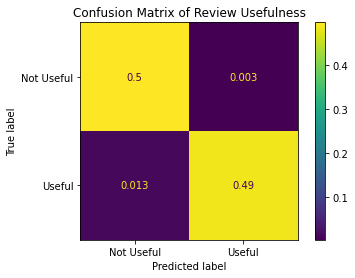

In [33]:
# Plot confusion matrix on training data
y_true = y_train
y_pred = (cnn_model.predict(X_train) >= 0.5).astype("int32")

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

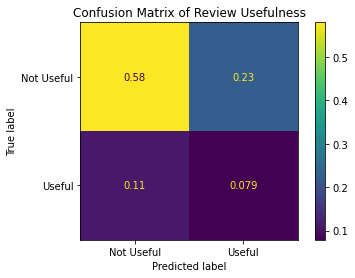

In [34]:
# Plot confusion matrix on test data
y_true = y_test
y_pred = (cnn_model.predict(X_test) >= 0.5).astype("int32")

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

In [35]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.72      0.77      4845
           1       0.26      0.41      0.32      1154

    accuracy                           0.66      5999
   macro avg       0.55      0.56      0.54      5999
weighted avg       0.72      0.66      0.68      5999



In [36]:
# Evaluate model
loss, acc = cnn_model.evaluate(X_test, y_test, verbose=1)
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print("Model performance metrics on test data")
print("Accuracy: {:.4f}\nLoss: {:.4f}\nPrecision: {:.4f}\nRecall: {:.4f}\nF1-score: {:.4f}".format(acc, loss, precision, recall, f1))

188/188 [==============================] - 1s 3ms/step - loss: 1.6769 - accuracy: 0.6586
Model performance metrics on test data
Accuracy: 0.6586
Loss: 1.6769
Precision: 0.7248
Recall: 0.6586
F1-score: 0.6847


In [37]:
example0 = "Golf tips magazine is one of the most aptly titled magazines available today. \
            It is chock full of heavily-illustrated exercises and other tips for serious golfers to improve their games.\
            \nThere are a number of golf magazines on the newstand today. Most of them rely on a lifestyle format relying \
            more heavily on lifestyle-type stories about today's hot golfers and the courses they play. Most of them include \
            a brief game tip or two but seem aimed at the casual duffer.\nGolf Tips, on the other hand, features almost nothing \
            but heavily illustrated tips on improving one's swing, eliminating mistakes and putting better. It also is heavily \
            loaded with features on the latest equipment technology. Each issue also seems to feature an article on the technical \
            aspects of a selected major golf course. The articles are written with terminology that serious golfers will understand \
            but that may confuse the weekend player. Judging by the amount of advertising in its early issues, this magazine also \
            appears to be financially healthy.\nIf a reader wants to read about the PGA Tour's superstars, this magazine is not for \
            him/her. But if s/he plans to be one of those superstars, Golf Tips is a good match."

example1 = "The information is interesting and fun, the writing is superb, and the writers and editors have a great sense of humor. \
            I just wish it came out more often!"

example2 = "this data science article is the best ever"

example3 = "i really loved how the technician helped me with the issue that i had"

example4 = "useless comment"

examples = [example0, example1, example2, example3, example4]

In [38]:
def test_examples(model, examples, num_len=512):
    for idx, example in enumerate(examples):
        sequence = tokenizer.texts_to_sequences([example])
        test = pad_sequences(sequence, maxlen=num_len)
        prediction = sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]
        print(idx, ":", prediction)

In [39]:
test_examples(cnn_model, examples)

0 : Not Useful
1 : Not Useful
2 : Not Useful
3 : Not Useful
4 : Not Useful


### X.X BERT - Combined

[TF BERT Tutorial](https://www.tensorflow.org/text/tutorials/classify_text_with_bert)

In [40]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 18.5 MB/s 
     |████████████████████████████████| 462 kB 56.1 MB/s 


In [41]:
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 16.6 MB/s 
     |████████████████████████████████| 99 kB 11.6 MB/s 
     |████████████████████████████████| 1.1 MB 49.8 MB/s 
     |████████████████████████████████| 1.2 MB 65.0 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 92 kB 6.7 MB/s 
     |████████████████████████████████| 352 kB 56.9 MB/s 
     |████████████████████████████████| 47.8 MB 46 kB/s 
     |████████████████████████████████| 237 kB 51.3 MB/s 


In [42]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

tf.get_logger().setLevel('ERROR')

In [43]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [44]:
reviews = review_samples['review_body'].fillna('no review')

X, y = reviews, labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

In [45]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [46]:
text_test = ['this is such an amazing movie!']
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.41171503]], shape=(1, 1), dtype=float32)


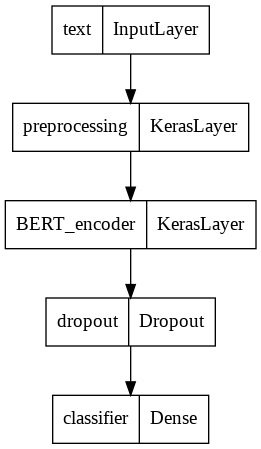

In [47]:
tf.keras.utils.plot_model(classifier_model)

In [48]:
loss_func = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [49]:
epochs = 10
steps_per_epoch = len(X_train)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [50]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss_func,
                         metrics=metrics)

In [51]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=X_train,
                               y=y_train,
                               validation_data=(X_dev, y_dev),
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/10
563/563 [==============================] - 141s 241ms/step - loss: 0.5139 - binary_accuracy: 0.8045 - val_loss: 0.4535 - val_binary_accuracy: 0.8113
Epoch 2/10
563/563 [==============================] - 137s 243ms/step - loss: 0.4583 - binary_accuracy: 0.8095 - val_loss: 0.4479 - val_binary_accuracy: 0.8113
Epoch 3/10
563/563 [==============================] - 138s 244ms/step - loss: 0.4505 - binary_accuracy: 0.8109 - val_loss: 0.4476 - val_binary_accuracy: 0.8106
Epoch 4/10
563/563 [==============================] - 137s 244ms/step - loss: 0.4484 - binary_accuracy: 0.8125 - val_loss: 0.4470 - val_binary_accuracy: 0.8106
Epoch 5/10
563/563 [==============================] - 137s 243ms/step - loss: 0.4422 - binary_accuracy: 0.8125 - val_loss: 0.4509 - val_binary_accuracy: 0.8114
Epoch 6/10
563/563 [==============================] - 137s 243ms/step - loss: 0.4380 - binary_accuracy: 0.81

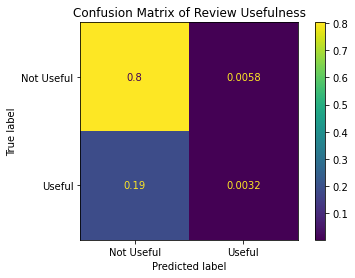

In [52]:
# Plot confusion matrix
y_true = y_test
y_pred = (classifier_model.predict(X_test) >= 0.5).astype("int32")

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

In [53]:
# Evaluate model
loss, acc = classifier_model.evaluate(X_test, y_test)
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print("Model performance metrics on test data")
print("Accuracy: {:.4f}\nLoss: {:.4f}\nPrecision: {:.4f}\nRecall: {:.4f}\nF1-score: {:.4f}".format(acc, loss, precision, recall, f1))

188/188 [==============================] - 18s 98ms/step - loss: 0.4990 - binary_accuracy: 0.8050
Model performance metrics on test data
Accuracy: 0.8050
Loss: 0.4990
Precision: 0.7211
Recall: 0.8050
F1-score: 0.7261
